<a href="https://colab.research.google.com/github/DanieleFoscarin/HDA2021/blob/main/time_Domain_ESC50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [173]:
!pip install livelossplot --quiet
from livelossplot import PlotLossesKeras

In [ ]:
! pip install optuna --quiet
import optuna

In [174]:
! pip install icecream --quiet
from icecream import ic

In [175]:
! pip install samplerate --quiet
import samplerate

In [176]:
from pathlib import Path
from scipy.io import wavfile
from IPython.display import Audio
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
import librosa
import librosa.display
from tqdm import tqdm, tqdm_notebook, notebook
import gc
import time 
import sys




import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import Sequence, SequenceEnqueuer   # try enquerer that uses parallelism
from tensorflow import keras
from tensorflow.keras.layers import BatchNormalization

#import model 
# from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

np.random.seed(42)

# Get Dataset

In [177]:
# Clone the entire repo.
!git clone https://github.com/karolpiczak/ESC-50.git


fatal: destination path 'ESC-50' already exists and is not an empty directory.


add columns for augmentation and mixup

augmentation = 0 means that it is the original file
mixup = -1 means that there's no mixup in that file

In [178]:
ROOT = '/content/ESC-50/audio/'

data_info = pd.read_csv(ROOT+"../meta/esc50.csv")

#make a category dictionary
category_dict = dict(zip(data_info['target'], data_info['category']))

#remove unused coumn and add other
aug_col = np.zeros((len(data_info),1))
mixup_col = -1 * np.ones((len(data_info),1))
data_info.drop('esc10', axis=1, inplace=True)
data_info.drop('src_file', axis=1, inplace=True)
data_info.drop('take', axis=1, inplace=True)

data_info['augmentation'] = aug_col
data_info['mixup'] = mixup_col

# one hot encoding from category
data_info = pd.get_dummies(data_info, columns=["category"], prefix='', prefix_sep='') 


data_info

,filename,fold,target,augmentation,mixup,airplane,breathing,brushing_teeth,can_opening,car_horn,cat,chainsaw,chirping_birds,church_bells,clapping,clock_alarm,clock_tick,coughing,cow,crackling_fire,crickets,crow,crying_baby,dog,door_wood_creaks,door_wood_knock,drinking_sipping,engine,fireworks,footsteps,frog,glass_breaking,hand_saw,helicopter,hen,insects,keyboard_typing,laughing,mouse_click,pig,pouring_water,rain,rooster,sea_waves,sheep,siren,sneezing,snoring,thunderstorm,toilet_flush,train,vacuum_cleaner,washing_machine,water_drops,wind
0,1-100032-A-0.wav,1,0,0.0,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1-100038-A-14.wav,1,14,0.0,-1.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1-100210-A-36.wav,1,36,0.0,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,1-100210-B-36.wav,1,36,0.0,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,1-101296-A-19.wav,1,19,0.0,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,5-263831-B-6.wav,5,6,0.0,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1996,5-263902-A-36.wav,5,36,0.0,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1997,5-51149-A-25.wav,5,25,0.0,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1998,5-61635-A-8.wav,5,8,0.0,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [179]:
#it is not necessary to read all the audio at the beginning
# TODO implement loading based on the dataframe filenames

ROOT = '/content/ESC-50/audio/'

audio_list = []
for audio in notebook.tqdm(sorted(Path(ROOT).iterdir())):
    try:
        # this_sound, sr = librosa.core.load(audio, sr=16000) #NB resampling to 16k
        sr, this_sound = wavfile.read(audio)
     #put in [-1,+1]
    except:
        print('cannot read ', str(audio))

    # downsampling is much faster with this library
    # this_sound = samplerate.resample(this_sound, 16000/44100, converter_type='sinc_fastest')
    audio_list.append(this_sound/32768)
    

print(len(audio_list))

print(np.shape(audio))
# audio_arr = np.array(audio_list)
# print(np.max(audio_arr), np.min(audio_arr))
#need normalization? insiede Sequence

ic(len(audio_list[0]))

KeyboardInterrupt: ignored

# Preprocessing functions

remeber to apply augmentation and mixup only on the training samples, foldwise

removing silence at the beginning or at the end of the audio clip

In [180]:
def removeSilence(signal, fill_silence=False):
    """
    Remove the leading and trailing zeros in an array,
    Parameters:
        signal: array,
        fill_silence: boolean, if True it repeats the non zero part until the 
            size of the output array is the same as the input array
    Return:
        an array

    """
    
    trimmed = np.trim_zeros(signal)
    if not fill_silence:
        return trimmed
    if fill_silence:
        lt = len(trimmed)
        ls = len(signal)
        # ic(lt,ls)
        if lt < ls:
          trimmed = np.tile(trimmed, int(np.ceil(ls/lt)))
          trimmed = trimmed[:ls]  
        return trimmed

# ic(len(audio_list[0]))
# a = removeSilence(audio_list[0], fill_silence=True)
# librosa.display.waveplot(a, sr=SR)
# ic(len(audio_list[0]))
# ic(len(a))
# # IPython.display.Audio(a, rate=sr)

In [181]:
def segmentation(y, seg_len, overlap=0, pad_end='off'):
    """ 
    Returns a list of array with same size, extracted from a signal
    parameters: 
        y: array, input signal
        seg_len: int, number of samples of the output segments
        overlap: int, number of samples overlapped between two segments
        pad_end: 'off': no padding,
                 'half': maximum padding is hald of seg_len,
                 'full': allows for the maximum number of segments. 
    return:
        a list of arrays.
    """
    y_len = len(y)
    # if seg_len > y_len or overlap > seg_len:        
    seg_begin = 0
    seg_end = seg_begin + seg_len
    seg_list = []
    

    if pad_end == 'full':
        pad = np.zeros((seg_len - overlap,))
        print(np.shape(pad))
        y = np.concatenate((y, pad)) 
        while seg_begin < y_len:
            seg_end = seg_begin + seg_len
            seg_list.append(y[seg_begin:seg_end])
            seg_begin = seg_begin + seg_len - overlap

    if pad_end == 'off':
        while seg_end < y_len:
            seg_end = seg_begin + seg_len
            seg_list.append(y[seg_begin:seg_end])
            seg_begin = seg_begin + seg_len - overlap
    
    if pad_end == 'half':
        pad = np.zeros((int(seg_len/2),))
        print(np.shape(pad))
        y = np.concatenate((y, pad)) 
        while seg_begin + seg_len < len(y):
            seg_end = seg_begin + seg_len
            seg_list.append(y[seg_begin:seg_end])
            seg_begin = seg_begin + seg_len - overlap
    #TODO more options on padding

    return seg_list


# out = segmentation(0.5*np.ones((12,)), 5, 0, pad_end='half')
# # print(np.shape(out))
# print(out)
# print(a)


Mixup function
It need one-hot encoding

In [182]:
# need to understand this

def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)


def mix_up(ds_one, ds_two, alpha=0.2):
    # Unpack two datasets
    # TODO adapt here
    images_one, labels_one = ds_one
    images_two, labels_two = ds_two
    batch_size = tf.shape(images_one)[0]

    # Sample lambda and reshape it to do the mixup
    l = sample_beta_distribution(batch_size, 0.2, 0.2)
    x_l = tf.reshape(l, (batch_size, 1, 1, 1))
    y_l = tf.reshape(l, (batch_size, 1))

    # Perform mixup on both images and labels by combining a pair of images/labels
    # (one from each dataset) into one image/label
    images = images_one * x_l + images_two * (1 - x_l)
    labels = labels_one * y_l + labels_two * (1 - y_l)
    return (images, labels)

# Online preprocessing and data augmentation

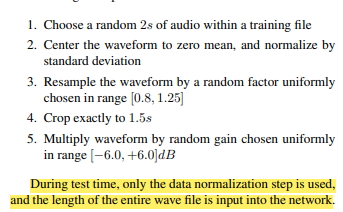

In [183]:
SR = 44100
SEG1_LEN = 2 * SR
SEG2_LEN = int(1.5 * SR)

# TODO add mixup in training mode

def onlinePreprocessing(this_filename, file_path,  mode='train'):
    #load the file from directory
    _, this_sound = wavfile.read(file_path+'/'+this_filename)
    # TODO downsampling

    if mode == 'train':
        # remove silence
        this_sound = removeSilence(this_sound, fill_silence=True)

        #pick a segment 
        start_idx = np.random.randint(0, len(this_sound)-SEG1_LEN)
        seg = this_sound[start_idx:start_idx+SEG1_LEN]

        #random resampling
        resample_factor = np.random.uniform(0.8, 1.25)
        seg = samplerate.resample(seg, resample_factor, converter_type='sinc_fastest')

        #crop to fixed length
        seg = seg[:SEG2_LEN]

        #standardization
        seg = (seg - np.mean(seg))/np.std(seg)

        #random gain change [-6,+6]dB
        gain_dB = np.random.uniform(-6,6)
        gain = 10**(gain_dB/20)
        seg = gain*seg


    if mode == 'test':
        # remove silence
        seg = removeSilence(this_sound, fill_silence=True)
        
        #standardization
        seg = (seg - np.mean(seg))/np.std(seg)

    
    return seg





## Dataloader

In [227]:
class AudioSequence(Sequence):
    
    def __init__(self, file_df, file_path, batch_size, mode='train', onehot=True):
        self.file_df = file_df
        self.file_path = file_path
        self.batch_size = batch_size
        self.mode = mode
        self.onehot = onehot



    def __len__(self):
        return int(np.ceil(len(self.file_df) / self.batch_size))


    def __getitem__(self, idx):
        

        batch_names = self.file_df.iloc[idx*self.batch_size:(idx + 1)*self.batch_size,0].to_numpy()
        if self.mode == 'train':
            batch_seg = np.zeros((self.batch_size, SEG2_LEN))
            for i in range(self.batch_size):
                batch_seg[i,:] = onlinePreprocessing(batch_names[i], self.file_path, mode=self.mode)
            # batch target need to change when using mixup
            if self.onehot:
                batch_target = self.file_df.iloc[idx*self.batch_size:(idx + 1)*self.batch_size, 5:].to_numpy()  #using onehot target
            else:
                batch_target = self.file_df.iloc[idx*self.batch_size:(idx + 1)*self.batch_size, 2].to_numpy()  #using onehot target

        if self.mode == 'test':
            # NB check what is the better management of silence in test mode
            batch_seg = np.zeros((self.batch_size, 5*SR))
            for i in range(self.batch_size):
                batch_seg[i,:] = onlinePreprocessing(batch_names[i], self.file_path, mode=self.mode)
            if self.onehot:
                batch_target = self.file_df.iloc[idx*self.batch_size:(idx + 1)*self.batch_size, 5:].to_numpy()  #using onehot target
            else:
                batch_target = self.file_df.iloc[idx*self.batch_size:(idx + 1)*self.batch_size, 2].to_numpy()

        return batch_seg, batch_target



In [226]:
dum_loader = AudioSequence(data_info.loc[data_info['fold']!=1], ROOT, 4, mode='test')
x,y = dum_loader[0]

ic(np.shape(x))
ic(np.shape(y))

ic| np.shape(x): (220500, 4)
ic| np.shape(y): (4, 50)


(4, 50)

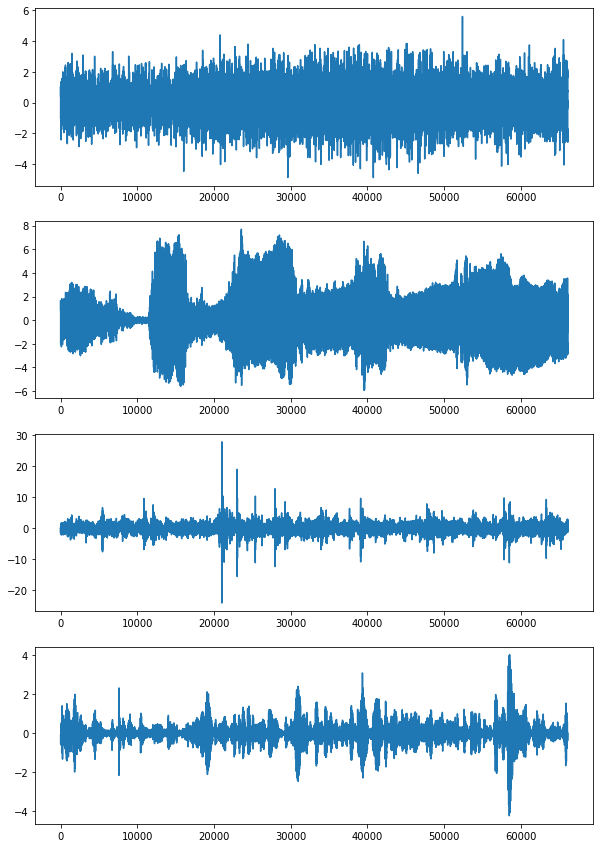

In [195]:
fig, ax = plt.subplots(4,1, figsize=(10,15))
npimg = np.zeros((4,3,60,431))

for i in range(4):
    ax[i].plot(x[:,i])


# NN Model

fully convolutional model based on AclNet

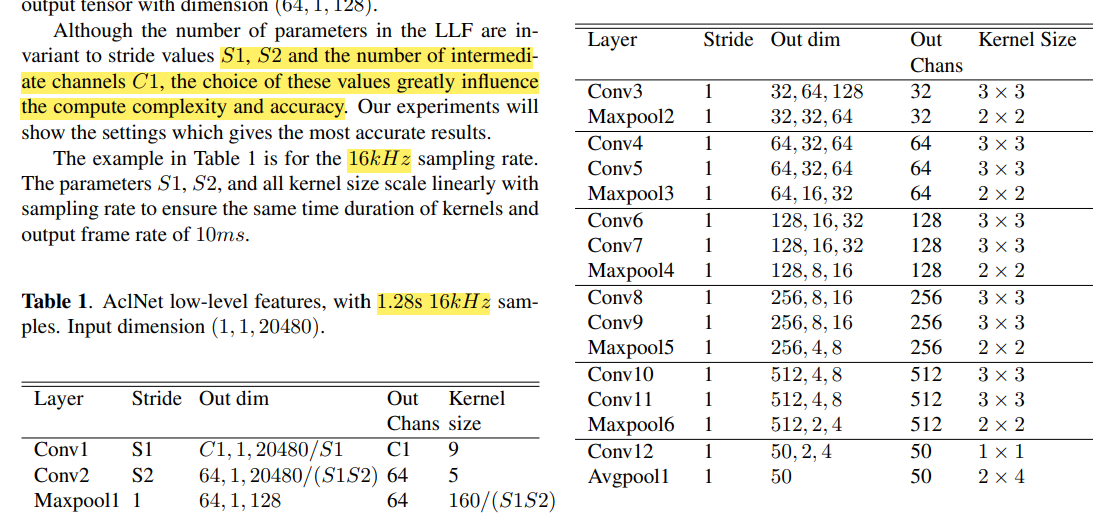

In [284]:
# TODO try depthwise convolution
def TdNet(c1, s1, s2, wm):

    # TODO how to make the input ok for different sizes?
    input = keras.Input(shape=(None, 1))
    # LLF
    x = layers.Conv1D(filters=c1, kernel_size=9,  strides=s1, padding='same', name='Conv1')(input)
    x = layers.Conv1D(filters=64, kernel_size=5, strides=s2, padding='same', name='Conv2')(x)
    x = layers.MaxPool1D(pool_size=int(SR*0.01/(s1*s2)), padding='same', name='Maxpool1')(x)
    x = tf.expand_dims(x, axis=3)

    # HLF
    x = layers.Conv2D(int(32*wm), (3,3), padding='same',  name='Conv3')(x)
    x = layers.ReLU()(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D(name='Maxpool2')(x)

    x = layers.Conv2D(int(64*wm), (3,3), padding='same', name='Conv4')(x)
    x = layers.ReLU()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(int(64*wm), (3,3), padding='same', name='Conv5')(x)
    x = layers.ReLU()(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D(name='Maxpool3')(x)

    x = layers.Conv2D(int(128*wm), (3,3), padding='same', name='Conv6')(x)
    x = layers.ReLU()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(int(128*wm), (3,3), padding='same', name='Conv7')(x)
    x = layers.ReLU()(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D(name='Maxpool4')(x)

    x = layers.Conv2D(int(256*wm), (3,3), padding='same', name='Conv8')(x)
    x = layers.ReLU()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(int(256*wm), (3,3), padding='same', name='Conv9')(x)
    x = layers.ReLU()(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D(name='Maxpool5')(x)

    x = layers.Conv2D(int(512*wm), (3,3), padding='same', name='Conv10')(x)
    x = layers.ReLU()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(int(512*wm), (3,3), padding='same', name='Conv11')(x)
    x = layers.ReLU()(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D(name='Maxpool6')(x)
 

    x = layers.Dropout(0,2)(x)
    x = layers.Conv2D(50, (1,1), padding='same', name='Conv12')(x)
    x = layers.ReLU()(x)
    x = layers.BatchNormalization()(x)
    x = layers.AveragePooling2D(pool_size=(4,2), name='Avgpool1')(x)
    x = layers.Softmax()(x)
   
    
    

    model = keras.Model(input, x, name='tdNet')
    return model

In [274]:
tdnet_1 = TdNet(8,2,2,wm=0.5)
tdnet_1.summary()

Model: "tdNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_59 (InputLayer)        [(None, None, 1)]         0         
_________________________________________________________________
Conv1 (Conv1D)               (None, None, 8)           80        
_________________________________________________________________
Conv2 (Conv1D)               (None, None, 64)          2624      
_________________________________________________________________
Maxpool1 (MaxPooling1D)      (None, None, 64)          0         
_________________________________________________________________
tf.expand_dims_41 (TFOpLambd (None, None, 64, 1)       0         
_________________________________________________________________
Conv3 (Conv2D)               (None, None, 64, 16)      160       
_________________________________________________________________
re_lu_263 (ReLU)             (None, None, 64, 16)      0     

# training configuration

In [285]:
tdnet_1 = TdNet(8,2,2,wm=0.5)
tdnet_1.compile(optimizer = keras.optimizers.Adam(),
                loss = keras.losses.categorical_crossentropy,
                metrics = ['accuracy'],
                )

# tdnet_1.compile(loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

batch_size = 20
epochs = 3
fold = 1
# df.loc[df['column_name'] == some_value]
train_dataloader = AudioSequence(data_info.loc[data_info['fold']!=fold], ROOT, batch_size, mode='train', )
val_dataloader = AudioSequence(data_info.loc[data_info['fold']==fold], ROOT, batch_size, mode='test', )

In [245]:
a = train_dataloader[10]
ic(np.shape(a[0]))
ic(np.shape(a[1]))

ic| np.shape(a[0]): (20, 66150)
ic| np.shape(a[1]): (20, 50)


(20, 50)

In [212]:
pred = tdnet_1.predict(val_dataloader)

In [214]:
ic(np.shape(pred))

ic| np.shape(pred): (4410000, 0, 1, 50)


(4410000, 0, 1, 50)

In [ ]:
dum_xx = np.random.uniform(0,1,size=(20, 64, 128, 1))

In [277]:
dum_x = np.random.uniform(0,1,size=(20, 66150,))
dum_y = np.zeros((20,50))
dum_y[:,0] = 1

tdnet_1.fit(x=dum_x,
            y=dum_y)

ValueError: ignored

In [286]:
history = tdnet_1.fit(train_dataloader, 
                        steps_per_epoch=int(len(train_dataloader)//batch_size),
                        epochs=epochs,
                        # callbacks=[PlotLossesKeras()],
                        validation_data=val_dataloader,
                        validation_steps=int(len(val_dataloader)//batch_size),
                        verbose=0,
                        )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


TypeError: ignored